# NextStrain Rabies metadata EDA

# Load libraries + data

In [2]:
from pathlib import Path
from collections import defaultdict, Counter

from Bio import SeqIO, SeqRecord

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_table("../data/nextstrain_rabies/metadata.tsv")

In [35]:
df.columns

Index(['accession', 'accession_version', 'strain', 'date', 'region', 'country',
       'division', 'location', 'length', 'host', 'host_latin_name',
       'host_family', 'host_genus', 'host_group', 'host_common_name',
       'date_released', 'date_updated', 'sra_accessions', 'authors',
       'abbr_authors', 'institution'],
      dtype='object')

# Sampling dates

In [5]:
# Invalid parsing will be set as NaT
df["date_dt_parsed"] = pd.to_datetime(df["date"], errors="coerce")

/var/folders/1t/rb_zhnrn44550d9pg40ct1n00000gn/T/ipykernel_44107/2141689063.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["date_dt_parsed"] = pd.to_datetime(df["date"], errors="coerce")


<Axes: xlabel='date_dt_parsed', ylabel='Count'>

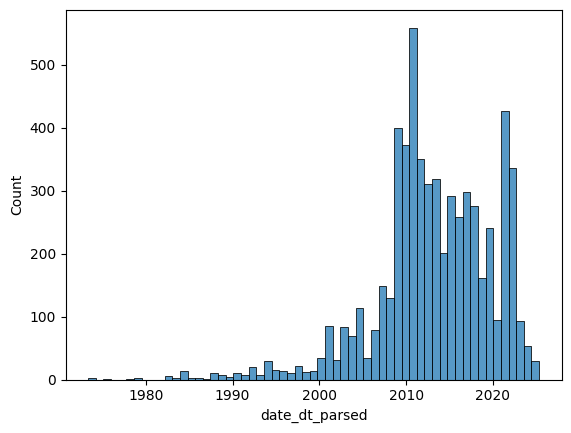

In [6]:
sns.histplot(data=df, x="date_dt_parsed")

**Did we lose data?**

In [7]:
print("Proportion of data with poorly entered dates:")
round(len(df[df["date_dt_parsed"].isna()]) / len(df), 3)

Proportion of data with poorly entered dates:


0.811

Answer: *YES*

## Dealing with bad dates

In [8]:
df["date"].value_counts().head()

date
XXXX-XX-XX    9767
2018-XX-XX     787
2008-XX-XX     748
2009-XX-XX     705
2006-XX-XX     652
Name: count, dtype: int64

In [9]:
print("Amount of incomplete dates:")
print(len(df[df["date"].str.contains("XX")]))
print("Amount of incomplete years:")
print(len(df[df["date"].str.contains("XXXX")]))

Amount of incomplete dates:
26099
Amount of incomplete years:
9767


## Manually years from date column

In [10]:
def get_year(date_str):
    if pd.isna(date_str):
        return pd.NA
    parts = str(date_str).split("-")
    if len(parts) == 3 and parts[0].isdigit():
        return int(parts[0])
    return pd.NA

In [11]:
df["year_parsed"] = df["date"].apply(get_year)

In [12]:
df["year_parsed"].value_counts().head(10)

year_parsed
2009    1435
2008    1189
2010    1113
2013    1091
2011    1083
2012    1083
2018    1050
2021     941
2014     885
2007     882
Name: count, dtype: int64

<Axes: xlabel='year_parsed', ylabel='Count'>

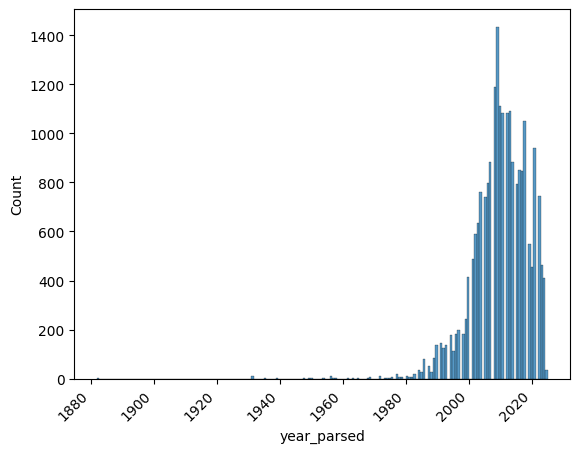

In [13]:
plt.xticks(rotation=45, ha="right")
sns.histplot(data=df, x="year_parsed")

Cutoff at year 2007

In [14]:
df_year_cutoff = df[df["year_parsed"] >= 2007]

<Axes: xlabel='year_parsed', ylabel='Count'>

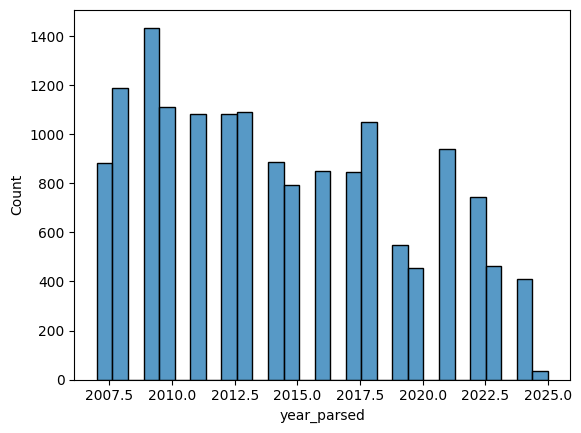

In [15]:
sns.histplot(data=df_year_cutoff, x="year_parsed")

# Stratifying by Host

## Host - year

In [16]:
crosstab_df = pd.crosstab(
    df_year_cutoff["host"], df_year_cutoff["year_parsed"], dropna=True
)
crosstab_df

year_parsed,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025
host,,,,,,,,,,,,,,,,,,,
?,56,20,7,14,17,7,28,11,14,6,13,6,4,12,15,49,11,6,0
Bat,97,53,96,111,134,171,53,31,47,21,28,76,47,34,100,89,59,4,0
Bird,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
Cattle,93,155,171,134,168,84,102,93,165,138,101,114,76,106,115,36,23,11,0
Domestic Dog,431,552,458,420,336,492,447,449,331,343,402,501,217,128,464,376,284,325,29
Fox (Vulpes sp.),48,103,168,188,75,69,75,44,31,20,30,29,26,18,28,43,4,2,0
Human,25,47,101,38,34,42,10,13,26,8,17,26,19,23,24,18,32,29,5
Other Carnivore,40,126,182,101,122,131,260,114,93,85,139,201,58,79,68,75,28,29,0
Other Mammal,2,10,0,3,4,3,3,21,2,3,6,4,16,2,23,11,2,0,0


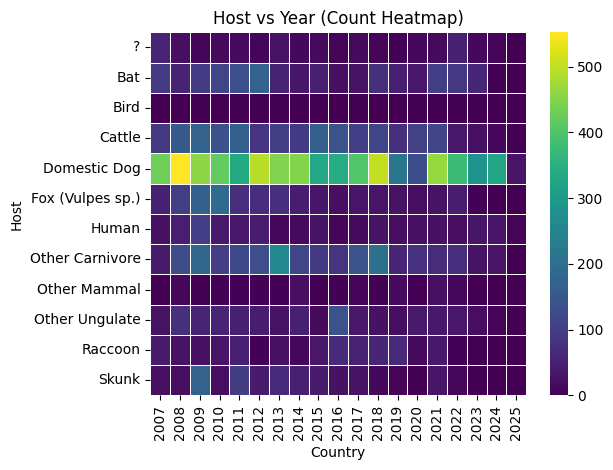

In [17]:
sns.heatmap(crosstab_df, cmap="viridis", linewidths=0.5)
plt.title("Host vs Year (Count Heatmap)")
plt.xlabel("Country")
plt.ylabel("Host")
plt.tight_layout()

## Host - Geographical

In [18]:
crosstab_df = pd.crosstab(df_year_cutoff["host"], df_year_cutoff["region"], dropna=True)
crosstab_df

region,Africa,Asia,Europe,North America,South America
host,,,,,
?,64,88,31,23,84
Bat,58,12,3,412,766
Bird,0,1,0,0,0
Cattle,318,414,200,48,903
Domestic Dog,2351,4100,262,91,163
Fox (Vulpes sp.),9,5,793,194,0
Human,38,462,7,12,18
Other Carnivore,515,658,428,261,65
Other Mammal,7,35,2,12,59


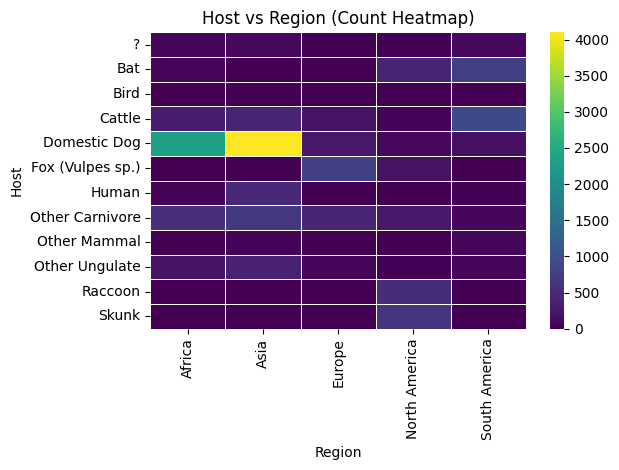

In [19]:
sns.heatmap(crosstab_df, cmap="viridis", linewidths=0.5)
plt.title("Host vs Region (Count Heatmap)")
plt.xlabel("Region")
plt.ylabel("Host")
plt.tight_layout()

# EDA on Prodigal gene-calling output

A quick BLAST on output for a given accession gives: 
* nucleoprotein
* phosphoprotein
* MAG matrix protein
* transmembrane glycoprotein
* L protein

**Question**: Same gene product order?

In [25]:
records = defaultdict(dict)
with open("../data/gene_called/proteins.faa", "rt", encoding="utf-8") as f:
    for sequence in SeqIO.parse(f, format="fasta"):
        name, id = sequence.name.split("_")
        records[name][id] = sequence.seq
records

defaultdict(dict,
            {'OM203138': {'1': Seq('MDADKIVFKVNNQVVSLKPEIIVDQYEYKYPAIKDLKKPCITLGKAPDLNKAYK...DS*'),
              '2': Seq('MSKIFVSPSAIRAGLADLEMAEETVDLINKNIEDNQAHLQGEPIEVDNLPEDMR...SC*'),
              '3': Seq('MNFLRKIVKNCRDEDTQKPSPVSAPPDDDDLWLPPPEYVPLKELTSKKNMKNFC...LE*'),
              '4': Seq('MVPQALWLVPLLGFSLCLGKFPIYTIPDKLGPWSPIDIHHLSCPNNLVVEDEGC...RL*'),
              '5': Seq('MLDPGEVYDDPIDPVESEAEPRGAPTVPNILRNSDYNLNSPLIEDPARLMLEWL...CL*')},
             'OM203141': {'1': Seq('MDADKIVFKVNNQVVSLKPEIIVDQYEYKYPAIKDLKKPCITLGKAPDLNKAYK...DS*'),
              '2': Seq('MSKIFVNPSAIRAGLADLEMAEETVDLINKNIEDNQAHLQGEPIEVDNLPEDMR...SC*'),
              '3': Seq('MNFLRKIVKNCRDEDTQKPSPVSAPPDDDDLWLPPPEYVPLKELTSKKNMKNFC...LE*'),
              '4': Seq('MVPQALLLVPLLGFSLCFGKFPIYTIPDKLGPWSPIDIHHLSCPNNLVVEDEGC...RL*'),
              '5': Seq('MLDPGEVYDDPIDPVESEAEPRGAPTVPNILRNSDYNLNSPLIEDPARLMLEWL...CL*')},
             'OM542185': {'1': Seq('MDADKIVFKVNNQVVSLKPEIIVDQYEYKYPAIKDLKKPC

In [24]:
length_at_position_d = defaultdict(list)
for name in records.keys():
    for id in records[name].keys():
        length_at_position_d[int(id)].append(len(records[name][id]))
length_at_position_d

defaultdict(list,
            {1: [452,
              452,
              451,
              451,
              451,
              451,
              451,
              451,
              451,
              451,
              451,
              451,
              451,
              451,
              451,
              451,
              451,
              1149,
              453,
              453,
              453,
              453,
              453,
              453,
              453,
              453,
              451,
              451,
              451,
              424,
              451,
              451,
              451,
              451,
              451,
              451,
              451,
              451,
              451,
              451,
              451,
              451,
              451,
              451,
              451,
              451,
              451,
              451,
              451,
              451,
              451,
         

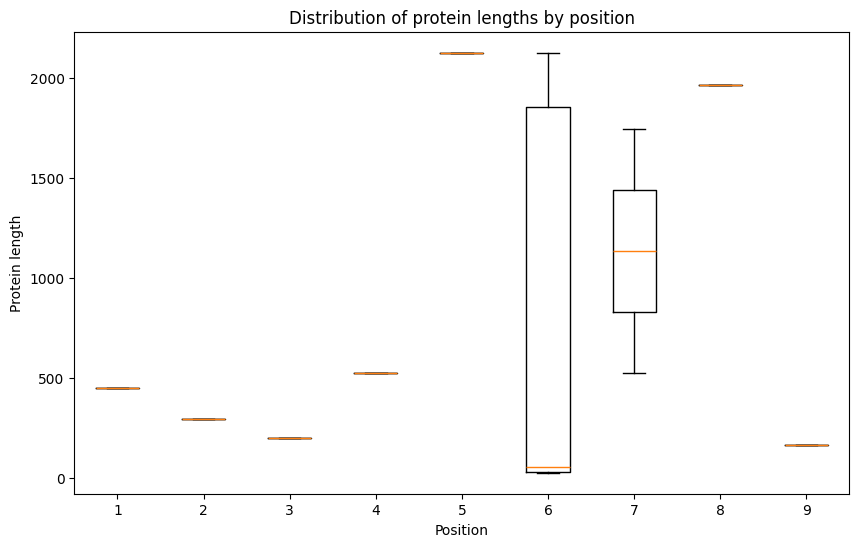

In [20]:
# Convert to aligned lists
positions = list(length_at_position_d.keys())
values = [length_at_position_d[pos] for pos in positions]

plt.figure(figsize=(10, 6))
plt.boxplot(values, positions=positions, showfliers=False)
plt.xlabel("Position")
plt.ylabel("Protein length")
plt.title("Distribution of protein lengths by position")
plt.show()

<Axes: ylabel='Count'>

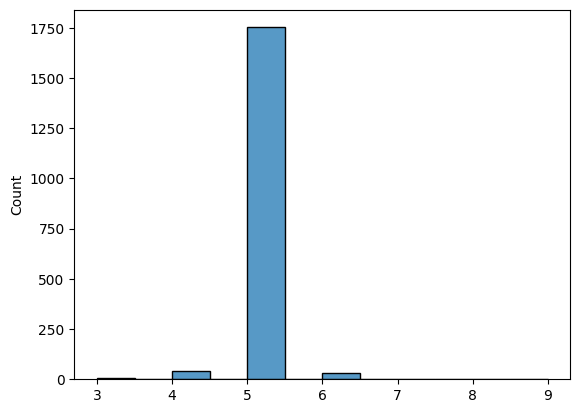

In [19]:
num_gene_products = []
for name in records.keys():
    num_gene_products.append(len(records[name].keys()))
sns.histplot(num_gene_products)

# Get timetree dates 

```
 csv file with dates for nodes with
                        'node_name, date' where date is float (as in
                        2012.15) or in ISO-format (YYYY-MM-DD).
                        Imprecisely known dates can be specified as
                        '2023-XX-XX' or [2013.2:2013.7]
```

In [5]:
df.columns

Index(['accession', 'accession_version', 'strain', 'date', 'region', 'country',
       'division', 'location', 'length', 'host', 'host_latin_name',
       'host_family', 'host_genus', 'host_group', 'host_common_name',
       'date_released', 'date_updated', 'sra_accessions', 'authors',
       'abbr_authors', 'institution'],
      dtype='object')

In [10]:
df_timetree = (
    df[["accession_version", "date"]].
    rename(columns={"accession_version" : "name"})
)
df_timetree

,name,date
0,OM203034.1,2018-XX-XX
1,OM203035.1,2018-XX-XX
2,OM203036.1,2019-XX-XX
3,OM203037.1,2019-XX-XX
4,OM203038.1,2019-XX-XX
...,...,...
32195,AB683612.2,2008-09-XX
32196,AB683613.2,2008-10-XX
32197,AB683614.1,2009-01-XX
32198,AB683615.2,2009-05-XX


In [11]:
df_timetree.to_csv("../data/timetree/dates.csv", index=False)

In [13]:
df[df["accession_version"] == "MF197745.1"]

,accession,accession_version,strain,date,region,country,division,location,length,host,...,host_family,host_genus,host_group,host_common_name,date_released,date_updated,sra_accessions,authors,abbr_authors,institution
5475,MF197745,MF197745.1,019N,1998-08-XX,Europe,Poland,Kuyavia-Pomerania,NaN,11966,Bat,...,Vespertilionidae,Cnephaeus,bats,Common serotine,2018-05-17,2018-05-17,NaN,"Smreczak,M.,Orlowska,A.,Marzec,A.,Trebas,P.,Zm...",Smreczak et al.,"National Veterinary Research Institute, Virolo..."
